In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import hstack, kron, eye, csc_matrix, block_diag
import galois
from pymatching import Matching

In [130]:
def repetition_code(n, shift):
    """
    Parity check matrix of a repetition code with length n.
    """
    row_ind, col_ind = zip(*((i, j) for i in range(n) for j in (i, (i+1)%n)))
    data = np.ones(2*n, dtype=np.uint8)
    H = csc_matrix((data, (row_ind, col_ind))).A
    return np.roll(H, shift, axis=1)

# def repetition_code(n, shift):


def toric_code_stabilisers(L, shift):
    """
    Sparse check matrix for the X stabilisers of a toric code with
    lattice size L, constructed as the hypergraph product of
    two repetition codes.
    """
    Hr = repetition_code(L, shift)
    Hz = hstack(
            [kron(Hr, eye(Hr.shape[1])).T, kron(eye(Hr.shape[0]), Hr.T)],
            dtype=int
        )
    Hx = hstack(
            [kron(eye(Hr.shape[1]), Hr), kron(Hr.T, eye(Hr.shape[0])).T],
            dtype=int
        )
    # Hx.data = Hx.data % 2
    # Hz.data = Hz.data % 2

    # return Hx, Hz
    Hx.eliminate_zeros()
    Hz.eliminate_zeros()
    return csc_matrix(Hx), csc_matrix(Hz)

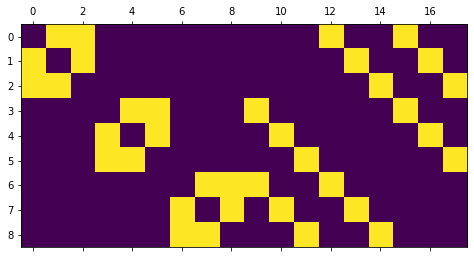

In [154]:
L = 3
Hx, Hz = toric_code_stabilisers(L, 1)
lattice = np.empty((2*L, 2*L), dtype=object)

plt.matshow(Hx.A)

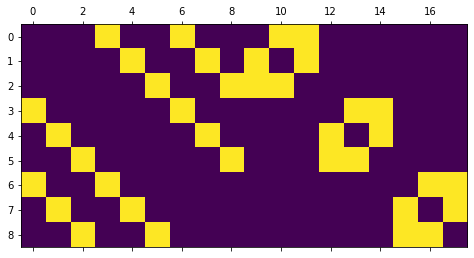

In [155]:
plt.matshow(Hz.A)

In [156]:
(Hx.A @ Hz.A.T) % 2

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [157]:
def available(pos):
    # returns list of available checks or qubits for a given position
    x, y = pos
    nbrs = [lattice[(x+1)%(2*L)][y], lattice[(x-1)%(2*L)][y], lattice[x][(y+1)%(2*L)], lattice[x][(y-1)%(2*L)]]

    num_nbrs = len([x for x in nbrs if x is not None])

    potentials = set(np.arange((2*L)**2))
    potentials = potentials ^ placed

    for nbr in nbrs:
        if nbr is None:
            continue

        if nbr[0] == "x":
            potentials = potentials.intersection(Hx[int(nbr[1:])].tocsr().indices)
        elif nbr[0] == "z":
            potentials = potentials.intersection(Hz[int(nbr[1:])].tocsr().indices)
        # elif neighbor[0] == "q":
        #     potentials.intersection(Hz[:, int(neighbor[1:])].indices)
        #     potentials.intersection(Hx[:, int(neighbor[1:])].indices)            

    return potentials

def find_most_neighbors():
    pos = None
    best_num_nbrs = 0
    for i in range(2*L):
        for j in range(2*L):
            if (lattice[i][j] is not None):
                continue
            nbrs = [lattice[(i+1)%(2*L)][j], lattice[(i-1)%(2*L)][j], lattice[i][(j+1)%(2*L)], lattice[i][(j-1)%(2*L)]]
            num_nbrs = len([x for x in nbrs if x is not None])

            if num_nbrs > best_num_nbrs:
                best_num_nbrs = num_nbrs
                pos = (i,j)
    return pos

def place_qubit(loc, qbt):
    x, y = loc
    lattice[x][y] = f"q{qbt}"  # {"type": 'q', "ind": 0}
    nbrs = [lattice[(x+1)%(2*L)][y], lattice[(x-1)%(2*L)][y], lattice[x][(y+1)%(2*L)], lattice[x][(y-1)%(2*L)]]

    if ((x % 2) == 0):
        placed_x_checks = [nbrs[2], nbrs[3]]
        placed_z_checks = [nbrs[0], nbrs[1]]

        for i, check in enumerate(Hx[:,qbt].indices):
            if f"x{check}" not in placed_x_checks:
                for j, x_check in enumerate(placed_x_checks):
                    if x_check is not None:
                        lattice[x][(y+(-1)**(j+1))%(2*L)] = f"x{check}"
        for i, check in enumerate(Hz[:,qbt].indices):
            if f"z{check}" not in placed_z_checks:
                for j, z_check in enumerate(placed_z_checks):
                    if z_check is not None:
                        lattice[(x+(-1)**(j+1))%(2*L)][y] = f"z{check}"
    else:
        placed_x_checks = [nbrs[0], nbrs[1]]
        placed_z_checks = [nbrs[2], nbrs[3]]

        for i, check in enumerate(Hx[:,qbt].indices):
            if f"x{check}" not in placed_x_checks:
                for j, x_check in enumerate(placed_x_checks):
                    if x_check is not None:
                        lattice[(x+(-1)**(j+1))%(2*L)][y] = f"x{check}"
        for i, check in enumerate(Hz[:,qbt].indices):
            if f"z{check}" not in placed_z_checks:
                for j, z_check in enumerate(placed_z_checks):
                    if z_check is not None:
                        lattice[x][(y+(-1)**(j+1))%(2*L)] = f"z{check}"

In [158]:

lattice = np.empty((2*L, 2*L), dtype=object)

qbt = 0
placed = {qbt}
x, y = (0,0)
lattice[x][y] = f"q{qbt}"  # {"type": 'q', "ind": 0}

if ((x % 2) == 0):
    for i, check in enumerate(Hx[:,qbt].indices):
        lattice[x][(y+(-1)**i)%(2*L)] = f"x{check}"
    for i, check in enumerate(Hz[:,qbt].indices):
        lattice[(x+(-1)**i)%(2*L)][y] = f"z{check}"
else:
    for i, check in enumerate(Hx[:,qbt].indices):
        lattice[(x+(-1)**i)%(2*L)][y] = f"x{check}"
    for i, check in enumerate(Hz[:,qbt].indices):
        lattice[x][(y+(-1)**i)%(2*L)] = f"z{check}"

while (np.count_nonzero(lattice) != (2*L)**2):
    loc = find_most_neighbors()
    qbt = available(loc)
    placed ^= qbt
    place_qubit(loc, list(qbt)[0])
print(lattice)

[['q0' 'x1' 'q2' 'x0' 'q1' 'x2']
 ['z3' 'q13' 'z5' 'q12' 'z4' 'q14']
 ['q6' 'x7' 'q8' 'x6' 'q7' 'x8']
 ['z0' 'q10' 'z2' 'q9' 'z1' 'q11']
 ['q3' 'x4' 'q5' 'x3' 'q4' 'x5']
 ['z6' 'q16' 'z8' 'q15' 'z7' 'q17']]


In [5]:
def par2gen(H):
    GF = galois.GF(2)
    gfH = GF(H)
    gfH_rank = np.linalg.matrix_rank(gfH)

    rref_H = gfH.row_reduce()

    swaps = []
    col_H = rref_H.copy()
    for i in range(gfH_rank):
        inds = np.where(col_H[i])[0]
        pivot = inds[0]
        col_H[:,[i,pivot]] = col_H[:,[pivot,i]]
        swaps.append((i,pivot))

    col_H = col_H[:gfH_rank]
    col_G = GF(np.hstack([col_H[:,gfH_rank:].T, np.eye(H.shape[1]-gfH_rank, dtype=int)]))

    G = col_G.copy()
    for swap in swaps[::-1]:
        G[:,[swap[1],swap[0]]] = G[:,[swap[0],swap[1]]]

    if (np.any(G @ rref_H[:gfH_rank].T) or np.any(col_G @ col_H.T)):
        print("FAILED")
        return
    return (np.array(G, dtype=int), np.array(col_G, dtype=int))


In [6]:
def commute(x, z, n):
    # 0 if commute, 1 if anticommute
    x1 = x[:n]
    x2 = x[n:]
    z1 = z[:n]
    z2 = z[n:]
    return (x1 @ z2 % 2) ^ (x2 @ z1 % 2)
    

def SGSOP(Gx, Gz, n):
    # symplectic gram-schmidt orthogonalization procedure
    sym_Gx = np.hstack([Gx, np.zeros(Gx.shape, dtype=int)])
    sym_Gz = np.hstack([np.zeros(Gz.shape, dtype=int), Gz])
    sym_G = np.vstack([sym_Gx, sym_Gz])
    logicals = []
    generators = []

    while(sym_G.shape[0]):
        g1 = sym_G[0]

        commutes = True
        for i in range(1, sym_G.shape[0]-1):
            g2 = sym_G[i]
            if (commute(g1,g2,n)):
                logicals.append((g1, g2))
                sym_G = np.delete(sym_G, [0, i], axis=0)

                for j in range(sym_G.shape[0]):
                    gj = sym_G[j]
                    sym_G[j] = gj ^ (commute(gj,g2,n) * g1) ^ (commute(gj,g1,n) * g2)
                commutes = False
                break
        
        if commutes:
            generators.append(g1)
            sym_G = np.delete(sym_G, 0, axis=0)
    
    return (logicals, generators)

In [7]:
def num_decoding_failures_vectorised(H, logicals, p, num_shots):
    matching = Matching.from_check_matrix(H, weights=np.log((1-p)/p), faults_matrix=logicals)
    noise = (np.random.random((num_shots, H.shape[1])) < p).astype(np.uint8)
    shots = (noise @ H.T) % 2
    actual_observables = (noise @ logicals.T) % 2
    predicted_observables = matching.decode_batch(shots)
    num_errors = np.sum(np.any(predicted_observables != actual_observables, axis=1))
    return num_errors

In [6]:
num_shots = 5000
Ls = range(4,14,4)
ps = np.linspace(0.01, 0.2, 9)
np.random.seed(2)
log_errors_all_L = []
for L in Ls:
    print("Simulating L={}...".format(L))
    Hx, Hz = toric_code_stabilisers(L)
    n = Hx.shape[1]
    Gx, col_Gx = par2gen(Hx.toarray())
    Gz, col_Gz = par2gen(Hz.toarray())
    logicals, generators = SGSOP(Gx, Gz, n)

    logX = np.array([l[1][n:] for l in logicals])
    logZ = np.array([l[0][:n] for l in logicals])
    log_errors = []
    for p in ps:
        num_errors = num_decoding_failures_vectorised(Hx, logX, p, num_shots)
        log_errors.append(num_errors/num_shots)
    log_errors_all_L.append(np.array(log_errors))

Simulating L=4...
Simulating L=8...
Simulating L=12...


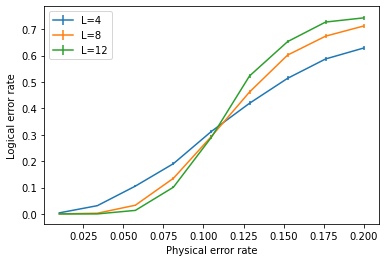

In [7]:
plt.figure()
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="L={}".format(L))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0)

In [8]:
Hx, Hz = toric_code_stabilisers(4)
n = Hx.shape[1]
Gx, col_Gx = par2gen(Hx.toarray())
Gz, col_Gz = par2gen(Hz.toarray())
logicals, generators = SGSOP(Gx, Gz, n)

logX = np.array([l[1][n:] for l in logicals])
logZ = np.array([l[0][:n] for l in logicals])

In [38]:
noise = np.zeros(Hx.shape[1], dtype=int)
noise[5] = 1
noise[30] = 1
shots = (noise @ Hx.T) % 2
shots.reshape((4,4))

array([[0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 1, 1]], dtype=int32)

In [39]:
matching = Matching.from_check_matrix(Hx)
predicted_error = matching.decode(shots)
np.where(predicted_error)

(array([ 5, 30], dtype=int64),)

In [40]:
masked_synd = shots.copy()
masked_synd[1] = 0
masked_synd[15] = 0
masked_synd.reshape((4,4))

array([[0, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 1, 0]], dtype=int32)

In [41]:
masked_matching = Matching.from_check_matrix(Hx)
masked_matching.set_boundary_nodes({1,15})
predicted_error = masked_matching.decode(masked_synd)
np.where(predicted_error)

(array([ 5, 30], dtype=int64),)